# Plot of stride cycle data

> [Laboratory of Biomechanics and Motor Control](http://pesquisa.ufabc.edu.br/bmclab)   
> Federal University of ABC, Brazil

In [1]:
import numpy as np
import pandas as pd
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
#matplotlib.rcParams['figure.dpi']=300  # inline figure resolution
#matplotlib.rc("savefig", dpi=300)      # saved figure resolution
import seaborn as sns
from ipywidgets import widgets, Layout
import glob
import sys, os

from scipy import signal
from scipy.signal import butter, filtfilt

sys.path.insert(1, './../functions')
from linear_envelope import linear_envelope
from tnorm import tnorm

## Helper functions

In [2]:
def moving_rms(x, window):
    """Moving RMS of 'x' with window size 'window'.
    """
    window = np.around(window).astype(np.int)
    return np.sqrt(np.convolve(x*x, np.ones(window)/window, 'same'))
    

def filter2(df, freq=1000, filt=True, fname=''):
    """Filter data
    """
    fc = 10
    # EMG
    for i in [0, 19]:
        #df.iloc[:, i] = linear_envelope(df.iloc[:, i].values, freq, Fc_bp=np.array([20, 400]), Fc_lp=fc)
        df.iloc[:, i] = moving_rms(df.iloc[:, i].values, window=freq/fc)
        df.iloc[:, i] = df.iloc[:, i]/df.iloc[:, i].max()
    # Accelerometer, Gyroscope, Magnetometer
    ch = np.arange(1, 38).tolist()
    ch.remove(19)
    if filt:
        for i in ch:
            b, a = butter(4, (fc/(freq/2)), btype = 'lowpass')
            df.iloc[:, i] = filtfilt(b, a, df.iloc[:, i]) 
    return df


def tnorm2(df, evs, fname=''):
    """Time normalization of data
    sn = ['EMG_taR',
          'ACCx_taR', 'ACCy_taR', 'ACCz_taR', 'GYRx_taR', 'GYRy_taR', 'GYRz_taR', 'MAGx_taR', 'MAGy_taR', 'MAGz_taR',
          'ACCx_tbR', 'ACCy_tbR', 'ACCz_tbR', 'GYRx_tbR', 'GYRy_tbR', 'GYRz_tbR', 'MAGx_tbR', 'MAGy_tbR', 'MAGz_tbR',
          'EMG_taL',
          'ACCx_taL', 'ACCy_taL', 'ACCz_taL', 'GYRx_taL', 'GYRy_taL', 'GYRz_taL', 'MAGx_taL', 'MAGy_taL', 'MAGz_taL',
          'ACCx_tbL', 'ACCy_tbL', 'ACCz_tbL', 'GYRx_tbL', 'GYRy_tbL', 'GYRz_tbL', 'MAGx_tbL', 'MAGy_tbL', 'MAGz_tbL',
          'FSR_hsR', 'FSR_toR',
          'FSR_hsL', 'FSR_toL']
    """
    right = list(range( 0, 19)) + [38, 39]
    left  = list(range(19, 38)) + [40, 41]
    data = np.empty((101, df.shape[1], evs.shape[0]-1))
    data.fill(np.nan)
    pages0 = []
    for ev in evs.index[:-1]:
        if not evs.iloc[[ev, ev+1]].isnull().values.any():
            data[:, right, ev], tn, indie = tnorm(df.iloc[int(evs.RHS[ev]):int(evs.RHS[ev+1]+1), right].values,
                                                  axis=0, step=1, k=3, smooth=0, mask=None,
                                                  nan_at_ext='delete', show=False, ax=None)
            data[:, left, ev], tn, indie  = tnorm(df.iloc[int(evs.LHS[ev]):int(evs.LHS[ev+1]+1), left].values,
                                                  axis=0, step=1, k=3, smooth=0, mask=None,
                                                  nan_at_ext='delete', show=False, ax=None)            
        else:
            pages0.append(ev)
    data = np.delete(data, pages0, axis=2)
    return data, tn


def ensemble(data, fname='', mean=True):
    """Ensemble average of data
    """
    if mean:
        ym = np.mean(data, axis=2)
        yq1, yq3 = np.std(data, axis=2, ddof=1), np.std(data, axis=2, ddof=1)
    else:
        ym = np.median(data, axis=2)
        yq1, yq3 = ym-np.percentile(data, 25, 2), np.percentile(data, 75, 2)-ym
    return ym, yq1, yq3


def calc_spatio_tempo(df):
    """ calculate spatio-temporal variables 
        RHS RHO LTS LTO LHS LHO RTS RTO
    """
    support_l = (df.LTO[1:] - df.LHS[:-1].values).dropna().mean()/(df.LHS.diff().dropna()).mean()
    support_r = (df.RTO[:-1] - df.RHS[:-1].values).dropna().mean()/(df.RHS.diff().dropna()).mean()
    #support_l = ((df.LTO[1:] - df.LHS[:-1].values)/df.LHS.diff().values[1:]).dropna()
    #support_r = ((df.RTO[:-1] - df.RHS[:-1].values)/df.RHS.diff().values[1:]).dropna()
    return [100*support_l, 100*support_r]  

    
def process_data(path2, trials, mean=True):
    """Process given data trials
    """
    datas = np.empty((101, 42, 1))
    support = []
    for trial in trials:
        df = read_data(os.path.join(path2, trial), debug=False)
        evs = read_events(os.path.join(path2, trial[:-4] + 'ev' + trial[5:]), debug=False)
        df = filter2(df, fname=trial)
        data, tn = tnorm2(df, evs, fname=trial)
        datas = np.append(datas, data, axis=2)
        support.append(calc_spatio_tempo(evs))
    datas = np.delete(datas, 0, axis=2)
    ym, yq1, yq3 = ensemble(datas, fname=trials, mean=mean)
    #support = np.mean(np.array(support), axis=0)
    
    return tn, ym, yq1, yq3, datas, support

## Information about the data files

In [3]:
# path of the dataset files
path2 = r'/mnt/DATA/X/GEDS/figshare'
# data sampling frequency
freq = 1000
# headers in the data files
sn = ['Time',
      'EMG_taR',
      'ACCx_taR', 'ACCy_taR', 'ACCz_taR', 'GYRx_taR', 'GYRy_taR', 'GYRz_taR',
      'MAGx_taR', 'MAGy_taR', 'MAGz_taR',
      'ACCx_tbR', 'ACCy_tbR', 'ACCz_tbR', 'GYRx_tbR', 'GYRy_tbR', 'GYRz_tbR',
      'MAGx_tbR', 'MAGy_tbR', 'MAGz_tbR',
      'EMG_taL',
      'ACCx_taL', 'ACCy_taL', 'ACCz_taL', 'GYRx_taL', 'GYRy_taL', 'GYRz_taL',
      'MAGx_taL', 'MAGy_taL', 'MAGz_taL',
      'ACCx_tbL', 'ACCy_tbL', 'ACCz_tbL', 'GYRx_tbL', 'GYRy_tbL', 'GYRz_tbL',
      'MAGx_tbL', 'MAGy_tbL', 'MAGz_tbL',
      'FSR_hsR', 'FSR_toR',
      'FSR_hsL', 'FSR_toL']
# files in the directory:
fnames = glob.glob(os.path.join(path2, 'S*[0-9]', 's*[1-6].txt'), recursive=True)
fnames.sort()
print('Number of data files:', len(fnames))
fnames_ev = glob.glob(os.path.join(path2, 'S*[0-9]', 's*ev.txt'), recursive=True)
fnames_ev.sort()
print('Number of event files:', len(fnames_ev))

Number of data files: 414
Number of event files: 414


## Read data

In [4]:
def read_data(fname, index_col=0, debug=False):
    """read resampled data from Desiree project.
    """
    df = pd.read_csv(fname, sep='\t', header=0, index_col=index_col, dtype=np.float64, engine='c') 
    if debug:
        print('Data shape: ({0}, {1})'.format(*df.shape))
    return df

df = read_data(fnames[0], debug=True)


def read_events(fname, drop_ext=True, debug=False):
    """read file with events data from Desiree project.
       RHS RHO LTS LTO LHS LHO RTS RTO
    """
    # the parameter na_values=0 below will replace 0 by NaN
    df = pd.read_csv(fname, sep='\t', header=0, index_col=None, na_values=0, engine='c')
    # drop first and last strides
    if drop_ext:  
        df = df.iloc[1:-1]  
        df.reset_index(drop=True, inplace=True)
    if debug:
        print('Event data shape: ({0}, {1})'.format(*df.shape))
    return df

evs = read_events(fnames_ev[0], debug=True)

Data shape: (35164, 42)
Event data shape: (33, 8)


## Process data in dataset

**This step is going to take a few minutes to run**

In [5]:
fnames = glob.glob(os.path.join(path2, 'S*[0-9]', 's*[1-6].txt'))
fnames = [os.path.basename(fname) for fname in fnames]
fnames.sort()
subjects = list(set([fname[:3] for fname in fnames]))
subjects.sort()
ym_a, yq1_a, yq3_a, datas_a, support_a = [], [], [], [], []

for subject in subjects:
    print(' ', subject, end='')
    for speed in ['c', 's', 'f']:
        print(speed, end='')
        trials = [fname for fname in fnames if fname[:4]==subject+speed]
        path_subj = os.path.join(path2, subject.upper())
        tn, ym, yq1, yq3, datas, support = process_data(path_subj, trials, mean=True)
        ym_a.append(ym)
        yq1_a.append(yq1)
        yq3_a.append(yq3)
        datas_a.append(datas)
        support_a.append(support)
print('\n', 'Done.', end='\n')        
# grand mean and sd (across subjects), don't include s00
ym_c, yq1_c, yq3_c = ensemble(np.dstack(datas_a[3+0::3]), mean=True)
ym_s, yq1_s, yq3_s = ensemble(np.dstack(datas_a[3+1::3]), mean=True)
ym_f, yq1_f, yq3_f = ensemble(np.dstack(datas_a[3+2::3]), mean=True)
gmeansd = [[ym_c, yq1_c, yq3_c], [ym_s, yq1_s, yq3_s], [ym_f, yq1_f, yq3_f]]

sup_c = np.vstack(support_a[3+0::3])
sup_s = np.vstack(support_a[3+1::3])
sup_f = np.vstack(support_a[3+2::3])
supm_c  = np.mean(sup_c, axis=0)
supq1_c = supm_c - np.std(sup_c, axis=0, ddof=1)
supq3_c = supm_c + np.std(sup_c, axis=0, ddof=1)
supm_s  = np.mean(sup_s, axis=0)
supq1_s = supm_s - np.std(sup_s, axis=0, ddof=1)
supq3_s = supm_s + np.std(sup_s, axis=0, ddof=1)
supm_f  = np.mean(sup_f, axis=0)
supq1_f = supm_f - np.std(sup_f, axis=0, ddof=1)
supq3_f = supm_f + np.std(sup_f, axis=0, ddof=1)
sup_msd = [[supm_c, supq1_c, supq3_c],
           [supm_s, supq1_s, supq3_s],
           [supm_f, supq1_f, supq3_f]]

  s00csf  s01csf  s02csf  s03csf  s04csf  s05csf  s06csf  s07csf  s08csf  s09csf  s10csf  s11csf  s12csf  s13csf  s14csf  s15csf  s16csf  s17csf  s18csf  s19csf  s20csf  s21csf  s22csf
 Done.


## Plot data

<IPython.core.display.Javascript object>


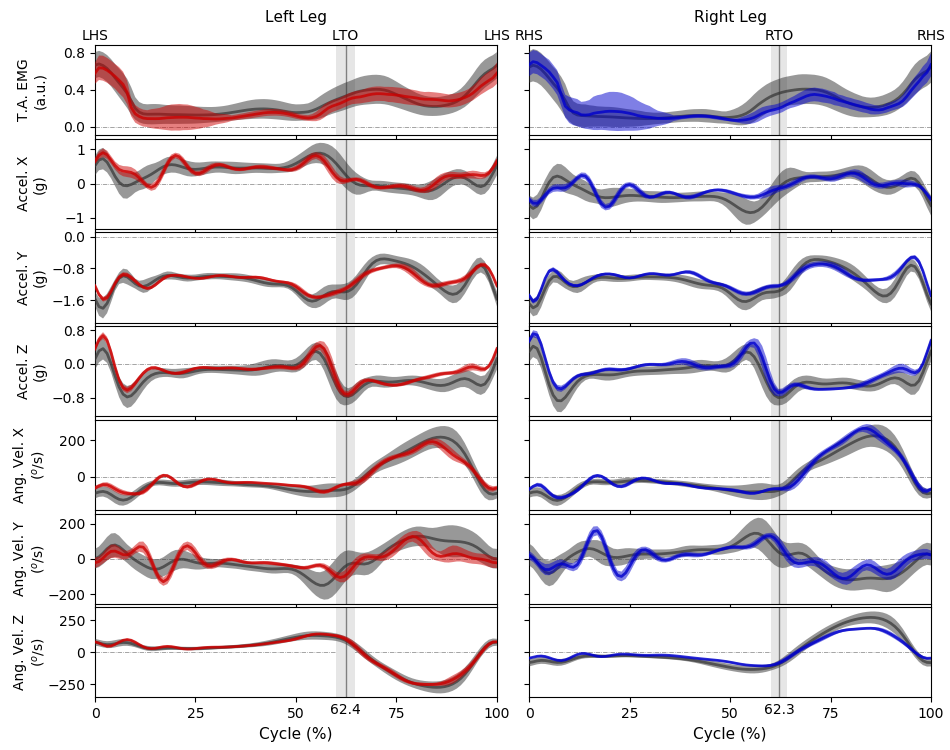

In [6]:
def plot_widget(path2, subjects, tn, ym_a, yq1_a, yq3_a, datas_a, gmeansd, sup_msd):
    """general plot widget of a pandas dataframe
    """
    from ipywidgets import widgets
      
    subject_w = widgets.Select(options=subjects, value=subjects[1], description='Subject',
                               layout=Layout(width='200px', height='80px'),
                               style = {'description_width': 'initial'})    
    speeds = [['Comfortable', 'Slow', 'Fast'], ['c', 's', 'f']]
    speed_w = widgets.Select(options=speeds[0], value=speeds[0][0], description='Speed',
                               layout=Layout(width='200px', height='80px'),
                               style = {'description_width': 'initial'}) 
    gmean_w = widgets.Checkbox(value=True, description='Plot grand mean',
                               layout=Layout(width='200px', height='20px'),
                               style = {'description_width': 'initial'})
    mean_w = widgets.Checkbox(value=True, description='Plot Mean',
                               layout=Layout(width='200px', height='20px'),
                               style = {'description_width': 'initial'})
    trials_w = widgets.Checkbox(value=False, description='Plot Trials',
                               layout=Layout(width='200px', height='20px'),
                               style = {'description_width': 'initial'})
    vbox = widgets.VBox(children=[gmean_w, mean_w, trials_w])
    container = widgets.HBox(children=[subject_w, speed_w, vbox])

    display(container)
    
    fig, axs = plt.subplots(7, 2, sharex='col', sharey='row', figsize=(9.5, 7.5))
    plt.subplots_adjust(left=.1, right=.98, bottom=0.07, top=.94, hspace=.04, wspace=.08)
    plt.show()
    
    def plot(change):    
        for ax in axs.flatten():
            ax.clear()
        fs = 10
        axs[0, 0].set_title('Left Leg', fontsize=11, y=1.16)
        axs[0, 1].set_title('Right Leg', fontsize=11, y=1.16)
        axs[0, 0].set_ylabel('T.A. EMG\n(a.u.)', fontsize=fs)    
        axs[1, 0].set_ylabel('Accel. X\n(g)', fontsize=fs)
        axs[2, 0].set_ylabel('Accel. Y\n(g)', fontsize=fs)
        axs[3, 0].set_ylabel('Accel. Z\n(g)', fontsize=fs)
        axs[4, 0].set_ylabel('Ang. Vel. X\n($^o$/s)', fontsize=fs)
        axs[5, 0].set_ylabel('Ang. Vel. Y\n($^o$/s)', fontsize=fs)
        axs[6, 0].set_ylabel('Ang. Vel. Z\n($^o$/s)', fontsize=fs)
        axs[-1, 0].set_xlabel('Cycle (%)', fontsize=11)
        axs[-1, 1].set_xlabel('Cycle (%)', fontsize=11)
        axs[0, 0].set_xlim(0, 100)
        axs[0, 1].set_xlim(0, 100)
            
        subject = subject_w.index
        speed = speed_w.index
               
        channels = [0, 1, 2, 3, 4, 5, 6]
        if mean_w.value:
            cgl = [.2, .2, .2, 0.5]
            cgml = [.2, .2, .2, 0.7]
            cgr = [.2, .2, .2, 0.5]
            cgmr = [.2, .2, .2, 0.7]
        else:
            cgl = [.8, .2, .2, 0.5]
            cgml = [.8, .2, .2, 0.8]
            cgr = [.2, .2, .8, 0.5]
            cgmr = [.2, .2, .8, 0.8]    
        cdbl = [.8, 0, 0, 0.5]
        cdbml = [.8, 0, 0, 0.8]
        cdbr = [0, 0, .8, 0.5]
        cdbmr = [0, 0, 0.8, 0.8]
        ci = [.3, 0.8, .3, .2]
        for c in channels:
            axs[c, 0].axhline(0, alpha=0.5, lw=.5, ls='-.', color='k', zorder=0)
            axs[c, 1].axhline(0, alpha=0.5, lw=.5, ls='-.', color='k', zorder=0)
            if gmean_w.value:
                axs[c, 0].axvspan(sup_msd[speed][1][0], sup_msd[speed][2][0],
                                  facecolor=[.9, .9, .9, 1], edgecolor='none', zorder=1)
                axs[c, 0].axvline(sup_msd[speed][0][0], lw=1, color=[.5, .5, .5], zorder=2)               
                axs[c, 1].axvspan(sup_msd[speed][1][1], sup_msd[speed][2][1], alpha=1,
                                  facecolor=[.9, .9, .9, 1], edgecolor='none', zorder=1)
                axs[c, 1].axvline(sup_msd[speed][0][1], lw=1, color=[.5, .5, .5], zorder=2)  
                ym, yq1, yq3 = gmeansd[speed][0], gmeansd[speed][1], gmeansd[speed][2]
                axs[c, 0].fill_between(tn, ym[:, c+19]+yq3[:, c+19], ym[:, c+19]-yq1[:, c+19],
                                       facecolor=cgl, edgecolor='none', zorder=3)
                axs[c, 0].plot(tn, ym[:, c+19], color=cgml, lw=2, zorder=4)
                axs[c, 1].fill_between(tn, ym[:, c]+yq3[:, c], ym[:, c]-yq1[:, c],
                                       facecolor=cgr, edgecolor='none', zorder=3)
                axs[c, 1].plot(tn, ym[:, c], color=cgmr, lw=2, zorder=4)
                
            if mean_w.value:
                ind = int(3*subject+speed)
                ym, yq1, yq3 = ym_a[ind], yq1_a[ind], yq3_a[ind]
                axs[c, 0].fill_between(tn, ym[:, c+19]+yq3[:, c+19], ym[:, c+19]-yq1[:, c+19],
                                       facecolor=cdbl, edgecolor='none', zorder=5)
                axs[c, 0].plot(tn, ym[:, c+19], color=cdbml, lw=2, zorder=6)
                axs[c, 1].fill_between(tn, ym[:, c]+yq3[:, c], ym[:, c]-yq1[:, c],
                                       facecolor=cdbr, edgecolor='none', zorder=5)
                axs[c, 1].plot(tn, ym[:, c], color=cdbmr, lw=2, zorder=6)
                
            if trials_w.value:
                datas = datas_a[int(3*subject+speed)]
                for i in range(datas.shape[2]):
                    axs[c, 0].plot(tn, datas[:, c+19, i], color=ci, lw=1, zorder=7)
                    axs[c, 1].plot(tn, datas[:, c, i], color=ci, lw=1, zorder=7)
        
        for row in range(7):
            axs[row, 0].yaxis.set_label_coords(-.12, 0.5)
            axs[row, 0].yaxis.set_major_locator(MaxNLocator(3))
            
        axs[-1, 0].xaxis.set_major_locator(MaxNLocator(4))
        axs[-1, 1].xaxis.set_major_locator(MaxNLocator(4))
        plt.text(x=0, y=1.05, s='LHS', fontsize=10, horizontalalignment='center', transform=axs[0, 0].transAxes)
        plt.text(x=1, y=1.05, s='LHS', fontsize=10, horizontalalignment='center', transform=axs[0, 0].transAxes)
        plt.text(x=0, y=1.05, s='RHS', fontsize=10, horizontalalignment='center', transform=axs[0, 1].transAxes)
        plt.text(x=1, y=1.05, s='RHS', fontsize=10, horizontalalignment='center', transform=axs[0, 1].transAxes)
        if gmean_w.value:
            xl = sup_msd[speed][0][0]/100
            plt.text(x=xl, y=1.05, s='LTO', fontsize=10,
                     horizontalalignment='center', transform=axs[0, 0].transAxes)
            plt.text(x=xl, y=-.18, s=np.around(xl*100, 1), fontsize=10,
                     horizontalalignment='center', transform=axs[-1, 0].transAxes)
            xr = sup_msd[speed][0][1]/100
            plt.text(x=xr, y=1.05, s='RTO', fontsize=10,
                     horizontalalignment='center', transform=axs[0, 1].transAxes) 
            plt.text(x=xr, y=-.18, s=np.around(xr*100, 1), fontsize=10,
                     horizontalalignment='center', transform=axs[-1, 1].transAxes)
            
    subject_w.observe(plot, names='value')
    speed_w.observe(plot, names='value')
    gmean_w.observe(plot, names='value')
    mean_w.observe(plot, names='value')
    trials_w.observe(plot, names='value')
    
    plot(True)
        
plot_widget(path2, subjects, tn, ym_a, yq1_a, yq3_a, datas_a, gmeansd, sup_msd)